# The need for speed without bothering too much: An introduction to `numba`


<img src="figures/numba_logo.png" style="display:block;margin:auto;width:60%;"/>

# Do you really need the speed?

* Write your Python program.
* Ensure it executes correctly and does what it is supposed to.
* Is it fast enough?
* If yes: Ignore the rest of the presentation.
* If no:
    1. Get it right.
    2. Test it's right.
    3. Profile if slow.
    4. Optimise (C, C++/Cython/`numba` and save yourself the pain).
    5. Repeat from 2.
    
> We *should forget* about small efficiencies, say about 97% of the time: **premature optimization is the root of all evil**.

> Yet we should not pass up our opportunities in that critical 3%. A good programmer will not be lulled into complacency by such reasoning, he will be wise to look carefully at the critical code; but only **after** that code has been identified.

<p style="text-align:right"><b>Donald Knuth</b></p>

# The need for speed

* For many programs, the most important resource is **developer time**.
* The best code is:
    * Easy to understand.
    * Easy to modify.
* But sometimes execution speed matters. Then what do you do?
* Go find a compiler!

# A Python compiler?

* Takes advantage of a simple fact:
    * Most functions in your program only use a small number of types.
* &rightarrow; Generate machine code to manipulate only the types you use!
* LLVM (Low Level Virtual Machine) library already implements a compiler backend.
   * It is used to construct, optimize and produce intermediate and/or binary machine code.
   * A compiler framework, where you provide the "front end" (parser and lexer) and the "back end" (code that converts LLVM's representation to actual machine code).
   * Multi platform.
   * LLVM optimizations (inlining, loop unrolling, SIMD vectorization etc).

# How can `numba` help?

* If you have big `numpy` arrays with your data (remember `pandas` uses `numpy` under-the-covers), `numba` makes it easy to write simple functions that are fast that work with that data.
* `numba` is an open source JIT (Just-In-Time) compiler for Python functions.
* From the types of the function arguments, `numba` can often generate a specialized, fast, machine code implementation at
runtime.
* Designed to work best with numerical code and `numpy` arrays.
* Uses the LLVM library as the compiler backend.


# `numba` features

* Numba generates optimized machine code from pure Python code using the LLVM compiler infrastructure. With a few simple annotations, array-oriented and math-heavy Python code can be JIT compiled to performance similar as C, C++ and Fortran, without having to switch languages or Python interpreters.
* `numba` supports:
    * Windows, OSX and Linux.
    * 32 and 64 bit CPUs and NVIDIA GPUs (CUDA).
    * `numpy`
* Does *not* require any C/C++ compiler.
* Does *not* replace the standard Python interpreter (all Python libraries are still available).
* Easy to install (`conda` not longer required): `pip install numba` (wheels for Windows/Linux/OSX are available, no need to compile anything).

# How `numba` works

<img src="figures/how_numba_works.png" style="display:block;margin:auto;width:90%;"/>

# `numba` modes of compilation

* **object mode**: Compiled code operates on Python objects. Supports nearly all of Python, but generally cannot speed up code by a large factor. Only significant improvement is the compilation of loops that can be compiled in *nopython* mode.
    * In object mode, Numba will attempt perform *loop lifting*, i.e. extract loops and compile them in *nopython* mode.
    * Works great for functions that are bookended by uncompilable code, but have a compilable core loop.
    * All happens automatically.
* **nopython mode**: Compiled code operates on native machine data. Supports a subset of Python, but runs close to C/C++/FORTRAN speed.

# **nopython** mode features
* Standard control and looping structures: `if`, `else`, `while`, `for`, `range`.
* `numpy` arrays, int, float, complex, booleans, and tuples.
* Almost all arithmetic, logical, and bitwise operators as well as functions from the math and numpy modules.
* Nearly all `numpy` dtypes: `int`, `float`, `complex`, `datetime64`, `timedelta64`.
* Array element access (read and write).
* Array reduction functions: `sum`, `prod`, `max`, `min`, etc.
* Calling other `nopython` mode compiled functions.
* Calling `ctypes` or `cffi` wrapped external functions.

# Supported Python features

* Built-in types: `int`, `bool`, `float`, `complex`, `bytes`.
* Container types: generators, lists, tuples and sets (with some restrictions).
* Built-in functions: Most builtin functions are supported, with some restrictions.
* Standard lib modules: `array` (limited support), `cmath`, `collections`, `ctypes`, `enum`, `math`, `operator`, `functools`, `random`.
* Third-party modules: `cffi` - Similarly to `ctypes`, `numba` is able to call into `cffi` declared external functions.

# Supported `numpy` features

* `numba` integrates seamlessly with `numpy`, whose arrays provide an efficient storage method for homogeneous sets of data and `numpy` *dtypes* provide type information useful when compiling.
* `numba` understands calls to `numpy` *ufuncs* and is able to generate equivalent native code for many of them.
* `numpy` arrays are directly supported in `numba`. Access to `numpy` arrays is very efficient, as indexing is lowered to direct memory accesses when possible.
* `numba` is able to generate *ufuncs* and *gufuncs*. This means that it is possible to implement ufuncs and gufuncs within Python, getting speeds comparable to that of ufuncs/gufuncs implemented in C extension modules using the `numpy` C API.

# `numpy` arrays and dtype objects

* `numpy`'s main object is the homogeneous multidimensional array. It is a table of elements, all of the same type, indexed by a tuple of positive integers. In `numpy` dimensions are called *axes*. The number of axes is *rank*.
* A data type object (an instance of `numpy.dtype` class) describes how the bytes in the fixed-size block of memory corresponding to an array item should be interpreted. It describes the type of the data (integer, float, Python object, etc.), size of the data (how many bytes is in e.g. the integer), byte order and some other parameters that further describe the data if it is e.g. a sub-array or an aggregate of other data types.

```python
>>> import numpy as np
>>> a = np.arange(15).reshape(3, 5)
>>> a
array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])
>>> a.shape
(3, 5)
>>> a.ndim
2
>>> a.dtype.name
'int64'
>>> np.ones( (2,3,4), dtype=np.int16 ) # dtype can also be specified
array([[[ 1, 1, 1, 1],
        [ 1, 1, 1, 1],
        [ 1, 1, 1, 1]],
       [[ 1, 1, 1, 1],
        [ 1, 1, 1, 1],
        [ 1, 1, 1, 1]]], dtype=int16)
```

# Basic usage

* **Lazy compilation**: Compilation will be deferred until the first function execution. `numba` will infer the argument types at call time, and generate optimized code based on this information. `numba` will also be able to compile separate specializations depending on the input types. 
```python
from numba import jit
#
@jit
def f(x, y):
    return x + y
```
* **Eager compilation**: `int32(int32, int32)` is the function’s signature. In this case, the corresponding specialization will be compiled by the `@jit` decorator, and no other specialization will be allowed. This is useful if you want fine-grained control over types chosen by the compiler (for example, to use single-precision floats).
```python
from numba import jit, int32
#
@jit(int32(int32, int32))
def f(x, y):
    return x + y
```

# Compilation options

* **`nopython`**: `numba` has two compilation modes: `nopython` mode and `object` mode. The former produces much faster code, but has limitations that can force `numba` to fall back to the latter. To prevent `numba` from falling back, and instead raise an error, pass `nopython=True`.
* **`nogil`**: Whenever `numba` optimizes Python code to native code that only works on native types and variables (rather than Python objects), it is not necessary anymore to hold Python’s global interpreter lock (GIL). `numba` will release the GIL when entering such a compiled function if you passed `nogil=True`.
* **`parallel`**: Enables an experimental feature that automatically parallelizes (and performs other optimizations for) those operations in the function known to have parallel semantics. This feature is enabled by passing `parallel=True` and must be used in conjunction with `nopython=True`:
* **`cache`**: To avoid compilation times each time you invoke a Python program, you can instruct `numba` to write the result of function compilation into a file-based cache. This is done by passing `cache=True`:

# Creating `numpy` universal functions with `@vectorize`

* `numba`'s vectorize allows Python functions taking scalar input arguments to be used as `numpy` ufuncs. Creating a traditional `numpy` ufunc is not not the most straightforward process and involves writing some C code. `numba` makes this easy. Using `@vectorize()`, `numba` can compile a pure Python function into a ufunc that operates over `numpy` arrays as fast as traditional ufuncs written in C.
* Using `@vectorize`, you write your function as operating over input scalars, rather than arrays. `numba` will generate the surrounding loop (or kernel) allowing efficient iteration over the actual inputs.

In [1]:
from numba import vectorize, float64
import numpy as np

@vectorize([float64(float64, float64)])
def f(x, y):
    return x + y

a = np.arange(6)
print(f(a,a))
a = np.linspace(0, 1, 6)
print(f(a,a))

[ 0.  2.  4.  6.  8. 10.]
[0.  0.4 0.8 1.2 1.6 2. ]


# Compiling python classes with `@jitclass`

`numba` supports code generation for classes via the `@jitclass` decorator. A class can be marked for optimization using this decorator along with a specification of the types of each field. We call the resulting class object a **jitclass**.
* *All methods* of a jitclass are compiled into `nopython` functions. The data of a jitclass instance is allocated on the heap as a C-compatible structure so that any compiled functions can have direct access to the underlying data, bypassing the interpreter.

In [2]:
import numpy as np
from numba import jitclass          # import the decorator
from numba import int32, float32    # import the types

spec = [
    ('value', int32),               # a simple scalar field
    ('array', float32[:]),          # an array field
]

@jitclass(spec)
class Bag(object):
    def __init__(self, value):
        self.value = value
        self.array = np.zeros(value, dtype=np.float32)

    @property
    def size(self):
        return self.array.size

    def increment(self, val):
        for i in range(self.size):
            self.array[i] = val
        return self.array

# More features

* **Flexible specializations with `@generated_jit`**: Sometimes you want to write a function that has different implementations depending on its input types. The `@generated_jit` decorator allows the user to control the selection of a specialization at compile-time, while retaining runtime execution speed of a JIT function.
* **Creating C callbacks with `@cfunc`**: Interfacing with some native libraries (for example written in C or C++) can necessitate writing native callbacks to provide business logic to the library. The `@cfunc` decorator creates a compiled function callable from foreign C code, using the signature of your choice.
* **Automatic parallelization with `@jit`**: Setting the `parallel` option for `@jit` enables an experimental Numba feature that attempts to automatically parallelize and perform other optimizations on (part of) a function.
* **CUDA support**: CUDA has an execution model unlike the traditional sequential model used for programming CPUs. In CUDA, the code you write will be executed by multiple threads at once (often hundreds or thousands). Your solution will be modeled by defining a thread hierarchy of grid, blocks and threads.`numba`'s CUDA support exposes facilities to declare and manage this hierarchy of threads. The facilities are largely similar to those exposed by NVidia’s CUDA C language.

# Example 1: Summation

In [3]:
from numba import jit

def psum(x):
    res = 0
    for i in range(x):
        res += i ** 2 + 1 + i
    return res

nsum = jit(psum)

%timeit -c psum(1000)
%timeit -c psum(100000)
%timeit -c nsum(1000)
%timeit -c nsum(100000000)

479 µs ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
49.1 ms ± 3.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
171 ns ± 1.96 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
172 ns ± 0.554 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


# Example 2: Fibonacci series

In [4]:
from numba import jit

def fib(n):
    a, b = 0, 1
    for i in range(n):
        a, b = b, a + b

    return a

nfib = jit(fib, nopython=True)

%timeit -c fib(1000)
%timeit -c nfib(1000)

72.5 µs ± 446 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
939 ns ± 6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [5]:
%load_ext cython

In [6]:
%%cython

def cfib(int n):
    cdef int i, a, b
    a, b = 0, 1
    for i in range(n):
        a, b = b, a + b
    return a

In [7]:
%timeit -c cfib(1000)

665 ns ± 4.34 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


# Example 3: Mandelbrot fractal

In [8]:
from timeit import default_timer as timer
from matplotlib.pylab import imshow, jet, show, ion
import numpy as np

from numba import jit

def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z * z + c
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i

    return 255

def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

5.93 s ± 17.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
49.1 ms ± 862 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


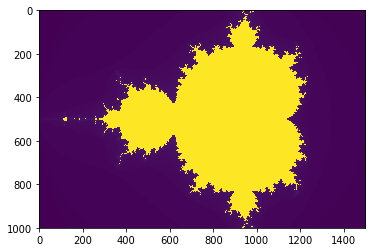

In [9]:
image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)
%timeit -c -r 3 create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)  # without numba
image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)
create_fractal, mandel = jit(create_fractal), jit(mandel)
%timeit -c create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)  # with numba
imshow(image)
show()

# Example 4: Diffusion controlled reaction

In [10]:
import numpy as np

RHO_0 = 0.25  # initial particle density
MCS = 10000  # Monte Carlo steps
RUNS = 10
DIM_0, DIM_1 = 81, 81

def init_lattice(rho=RHO_0, dim0=DIM_0, dim1=DIM_1):
    """Place particles on lattice with density rho."""
    lat = np.zeros(shape=(dim0, dim1), dtype=np.int32)

    for i in range(lat.shape[0]):
        for j in range(lat.shape[1]):
            if np.random.random() <= rho:
                lat[i, j] = 1

    return lat

def execute_mcs(lat):
    """Move each particle on the lattice once in a random direction."""
    lat_t0 = np.copy(lat)  # lattice at time t0

    for i in range(lat_t0.shape[0]):
        for j in range(lat_t0.shape[1]):
            if lat_t0[i, j] == 1:  # we found a particle
                r = np.random.randint(4)
                i1, j1 = i, j

                # move particle up/down/left right
                if r == 0: i1 += 1
                if r == 1: i1 -= 1
                if r == 2: j1 += 1
                if r == 3: j1 -= 1

                # boundary conditions
                if i1 < 0: i1 = 0
                if i1 > lat.shape[0] - 1: i1 = lat.shape[0] - 1
                if j1 < 0: j1 = 0
                if j1 > lat.shape[1] - 1: j1 = lat.shape[1] - 1

                # check trap
                if i1 == lat.shape[0] // 2 and j1 == lat.shape[1] // 2:
                    # we hit the center (trap), remove the particle
                    lat[i, j] = 0
                elif not lat[i1, j1]:
                    # new position is empty, move particle
                    lat[i, j] = 0
                    lat[i1, j1] = 1

def calc_rho(lat):
    return np.sum(lat) / lat.size

def execute_simulation(runs=RUNS, mcs=MCS, rho_0=RHO_0):
    rho_t = np.zeros(mcs, dtype=np.float)

    for r in range(runs):
        lat = init_lattice()
        for m in range(mcs):
            rho_t[m] += calc_rho(lat)
            execute_mcs(lat)

    for i in range(rho_t.shape[0]):
        rho_t[i] /= (runs * rho_0)

    return rho_t

%timeit -c execute_simulation(runs=1, mcs=1000)

7.75 s ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


58.7 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


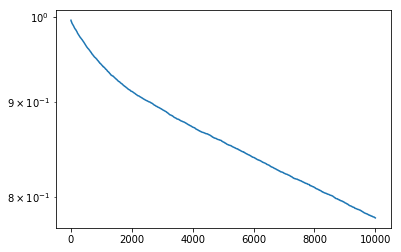

In [11]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt

RHO_0 = 0.25  # initial particle density
MCS = 10000  # Monte Carlo steps
RUNS = 10
DIM_0, DIM_1 = 81, 81

@jit(nopython=True)
def init_lattice(rho=RHO_0, dim0=DIM_0, dim1=DIM_1):
    """Place particles on lattice with density rho."""
    lat = np.zeros(shape=(dim0, dim1), dtype=np.int32)

    for i in range(lat.shape[0]):
        for j in range(lat.shape[1]):
            if np.random.random() <= rho:
                lat[i, j] = 1

    return lat

@jit(nopython=True)
def execute_mcs(lat):
    """Move each particle on the lattice once in a random direction."""
    lat_t0 = np.copy(lat)  # lattice at time t0

    for i in range(lat_t0.shape[0]):
        for j in range(lat_t0.shape[1]):
            if lat_t0[i, j] == 1:  # we found a particle
                r = np.random.randint(4)
                i1, j1 = i, j

                # move particle up/down/left right
                if r == 0: i1 += 1
                if r == 1: i1 -= 1
                if r == 2: j1 += 1
                if r == 3: j1 -= 1

                # boundary conditions
                if i1 < 0: i1 = 0
                if i1 > lat.shape[0] - 1: i1 = lat.shape[0] - 1
                if j1 < 0: j1 = 0
                if j1 > lat.shape[1] - 1: j1 = lat.shape[1] - 1

                # check trap
                if i1 == lat.shape[0] // 2 and j1 == lat.shape[1] // 2:
                    # we hit the center (trap), remove the particle
                    lat[i, j] = 0
                elif not lat[i1, j1]:
                    # new position is empty, move particle
                    lat[i, j] = 0
                    lat[i1, j1] = 1

@jit(nopython=True)
def calc_rho(lat):
    return np.sum(lat) / lat.size

@jit(nopython=True)
def execute_simulation(runs=RUNS, mcs=MCS, rho_0=RHO_0):
    rho_t = np.zeros(mcs, dtype=np.float32)

    for r in range(runs):
        lat = init_lattice()
        for m in range(mcs):
            rho_t[m] += calc_rho(lat)
            execute_mcs(lat)

    for i in range(rho_t.shape[0]):
        rho_t[i] /= (runs * rho_0)

    return rho_t

%timeit -c execute_simulation(runs=1, mcs=1000)
rho_t = execute_simulation()
plt.plot(rho_t)
plt.yscale('log')
plt.show()

# References

1. [Stanley Seibert - Accelerating Python with the Numba JIT Compiler (SciPy 2015)](https://www.youtube.com/watch?v=eYIPEDnp5C4)
* Stanley Seibert - Numba: A JIT Compiler for Scientific Python (Continuum Analytics 2015)
* Travis E. Oliphant - Performance Python: Introduction to Numba (PyData 2015)
* [Numpy documentation](https://docs.scipy.org/doc/)
* [Numba documentation](http://numba.pydata.org)
* [Numba examples](https://github.com/numba/numba/blob/master/examples)